In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import cftime
import datetime
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, Normalize
import matplotlib.patches as patches
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import cartopy as cart
#import imageio
import scipy.stats as stats
#import pingouin as pg
import random
import calendar

from CE_Functions import *
from ClimateModesForCEs import *
from PlottingForCEs import *

mpl.rcParams['figure.dpi'] = 300

In [5]:
era5 = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/era5_raw.nc')
era5['tp'].to_netcdf('era5_tp_raw.nc')


In [6]:
xr.open_dataset('/Users/aedwyer/Documents/CEs/era5_tp_raw.nc')

<xarray.Dataset> Size: 17GB
Dimensions:    (longitude: 1440, latitude: 721, expver: 2, time: 1011)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-03-01
Data variables:
    tp         (time, expver, latitude, longitude) float64 17GB ...

Load in files, data preprocessing

In [2]:
# Regridded ERA5 Data
era5 = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/Regridded_ERA5.nc')
expver1 = era5.sel(expver = 1)
lat = era5['lat']
lon = era5['lon']

## CALL IN MODES ##

# Calling in the ENSO indices, using the file of ENSO indices that we used in Climate
# Values from January 1950 to January 2024
nino_34_file_path = '/Users/aedwyer/Documents/Classes/Climate/detrend.nino34.ascii.txt'
nino_34 = pd.read_csv(nino_34_file_path, delim_whitespace=True)
nino_34_anoms = nino_34['ANOM'].values

# Calling in PDO and then revamping the file. 
pdo_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/monthly_pdo_indices.txt'
pdo_indices = pd.read_csv(pdo_file_path, delim_whitespace=True, skiprows = 1)
pdo_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# pull out the anomalies for the hadCRUT5 file and drop the other rows
pdo_melted = pdo_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
# switch the months to numbers so readabaility between nino indices and hadcrut5 indices are easier
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
pdo_melted['Month'] = pdo_melted['Month'].map(month_to_num)
pdo_sorted = pdo_melted.sort_values(by=['Year', 'Month']).reset_index(drop=True)
pdo_anoms = pdo_sorted['Anomaly'].values
pdo_anoms_1950_2024 = pdo_anoms[1152:2040]

nao_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/nao_station_monthly.txt'
nao_indices = pd.read_csv(nao_file_path, delim_whitespace = True, header =1)
nao_indices.insert(0, 'Index', nao_indices.index)
nao_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# pull out the anomalies for the hadCRUT5 file and drop the other rows
nao_melted = nao_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
# switch the months to numbers so readabaility between nino indices and hadcrut5 indices are easier
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
nao_melted['Month'] = nao_melted['Month'].map(month_to_num)
nao_sorted = nao_melted.sort_values(by=['Year', 'Month']).reset_index(drop=True)
nao_anoms = nao_sorted['Anomaly'].values
nao_anoms_1950_2023 = nao_anoms[1020:-12]


iod_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/IOD_indices.txt'
with open(iod_file_path, 'r') as file:
    total_lines = sum(1 for line in file)
iod_indices = pd.read_csv(iod_file_path, delim_whitespace=True, skiprows = 1, nrows = total_lines - 10 )
iod_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
iod_melted = iod_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
iod_melted['Month'] = iod_melted['Month'].map(month_to_num)
iod_sorted = iod_melted.sort_values(by = ['Year', 'Month']).reset_index(drop=True)
iod_anoms = iod_sorted['Anomaly'].values
iod_anoms_1950_2024 = iod_anoms[948:]


## CALCULATE PRECIP RATE FROM ERA5 DATA ##
# Calculate the number of seconds in each month
# precipitation is already m/day not just m, so just need to divide by the s in a day not the actual month, I am going to keep the rest though in a comment just in case.
seconds_per_month = []

for year in range(1940, 2024):  
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        seconds_in_month = 24 * 60 * 60 # * days_in_month
        seconds_per_month.append(seconds_in_month)

# Create a DataArray for seconds per month
seconds_per_month_da = xr.DataArray(seconds_per_month, dims=('time',), coords={'time': era5['time'][:1008]})

total_precip_rate = expver1['tp'][:1008] / seconds_per_month_da  # Seconds in a month
total_precip_rate = total_precip_rate[:1008]
temps = expver1['t2m'][:1008] - 273.15

surface_temps = expver1['skt'][:1008] - 273.15

## DETREND ERA5 DATA USING THIRD ORDER POLYNOMIALS ##
# Group Temperatures into months
month_indices_temps = temps.groupby('time.month')

# Create the list that will hold the temperatures once they are detrended
temps_detrended_list = []
fit_list = []
for i in range(1,13):
    # fit the third order polynomial
    line_fit = month_indices_temps[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_temps[i].time, line_fit.polyfit_coefficients)
    fit_list.append(fit)
    # subtract the polynomial from the actual data
    temps_detrended = month_indices_temps[i] - fit

    # Append to the list
    temps_detrended_list.append(temps_detrended)

# create xarray to that of the temperatures to store all the values
detrended_2m_temps = xr.zeros_like(temps)

# Loop through all the months and append the detrended values to the empty xarray
for i in range(1, 13):
    temps_month = month_indices_temps.groups[i]
    detrended_2m_temps[temps_month] = temps_detrended_list[i-1]


# Group Precip into months
month_indices_precip = total_precip_rate.groupby('time.month')

# Create the list that will hold the precip values once they are detrended
precip_detrended_list = []
fit_list_precip = []
for i in range(1,13):
    # fit the third order polynomial
    line_fit = month_indices_precip[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_precip[i].time, line_fit.polyfit_coefficients)
    fit_list_precip.append(fit)
    # subtract the polynomial from the actual data
    precip_detrended = month_indices_precip[i] - fit

    # Append to the list
    precip_detrended_list.append(precip_detrended)

# create xarray to that of the precipitaiton values to store all the values
detrended_precip = xr.zeros_like(total_precip_rate)
# Loop through all the months and append the detrended values to the empty xarray
for i in range(1, 13):
    precip_month = month_indices_precip.groups[i]
    detrended_precip[precip_month] = precip_detrended_list[i-1]


month_indices_surface_temps = surface_temps.groupby('time.month')
surface_temps_detrended_list = []
fit_list_ts = []
for i in range(1,13):
    line_fit = month_indices_surface_temps[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_surface_temps[i].time, line_fit.polyfit_coefficients)
    fit_list_ts.append(fit)
    ts_detrended = month_indices_surface_temps[i] - fit
    surface_temps_detrended_list.append(ts_detrended)


detrended_surface_temps = xr.zeros_like(surface_temps)
for i in range(1, 13):
    temps_month = month_indices_surface_temps.groups[i]
    detrended_surface_temps[temps_month] = surface_temps_detrended_list[i-1]

/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62514/624611585.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino_34 = pd.read_csv(nino_34_file_path, delim_whitespace=True)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62514/624611585.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdo_indices = pd.read_csv(pdo_file_path, delim_whitespace=True, skiprows = 1)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62514/624611585.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao_indices = pd.read_csv(nao_file_path, delim_whitespace = True, header =1)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62514/624611585.py:47: FutureWarning: The 'd

CHECK FOR DETREND, TIMESERIES FOR FORT COLLINS WITH THE THIRD ORDER POLYNOMIAL

In [ ]:
surface_temps_detrended_list[6].sel(lat = 40.99, lon = 255, method = 'nearest').plot(label = 'Detrended July TS')
month_indices_surface_temps[7].sel(lat = 40.99, lon = 255, method = 'nearest').plot(label = 'July TS')
fit_list_ts[6].sel(lat = 40.99, lon = 255, method = 'nearest').plot(label = 'the fit')
plt.legend()
plt.title('Fort Collins July TS Values from 1940-2023')

CE CALCULATION, Quantiles Per Month

In [3]:
sum_freq = 0

month_indices_trefht = detrended_2m_temps.groupby('time.month')

month_indices_prect = detrended_precip.groupby('time.month')

# Find Quantiles
trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

ce_binary = xr.zeros_like(detrended_2m_temps)

for i in range(1, 13):
    trefht_month = month_indices_trefht.groups[i]
    prect_month = month_indices_prect.groups[i]
    ce_binary[trefht_month] = ((detrended_2m_temps[trefht_month] >= trefht_quants[i-1]) & 
                                (detrended_precip[prect_month] <= prect_quants[i-1])) * 1
    

# add the frequency to the sum
sum_freq = ((ce_binary == 1).sum(axis = 0) / len(ce_binary['time'])) * 100

PLOT FREQUENCIES FOR ERA5 DATA

In [ ]:
lat_threshold = -57

mask = sum_freq['lat'] >= lat_threshold
masked_lat = sum_freq['lat'][mask]
masked_data = sum_freq.isel(lat = mask)

plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.EqualEarth()) 
plt.pcolormesh(sum_freq['lon'], sum_freq['lat'], sum_freq, cmap = 'Reds', transform = ccrs.PlateCarree(), vmin = 0, vmax = 4)
#plt.colorbar(label = 'Frequency (%)', orientation = 'horizontal', fraction = 0.05, extend = 'max', pad = 0.01)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cart.feature.LAKES, edgecolor = 'black', facecolor = 'white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')


plt.title('b) ERA5 Frequencies, 1940-2024', size = 20)

Plotting Composite Surface Temperature Map for Compound Event

In [ ]:
## DEFINE LOCATION COORDIANTES ##
lat_c_comp = -32.51
lon_c_comp = 150

# Create list to hold all the true indices for compound events for one location
true_indices_list = []

# pick out one location
location_ces_each_member = ce_binary[:1008].sel(lat = lat_c_comp, lon = lon_c_comp, method = 'nearest')
# pull out the true indicies 
true_indices = [index for index, value in enumerate(location_ces_each_member) if value]

# append the true indices to a list to call later
true_indices_list.append(true_indices)


# temperature sum to average for the composite map
temp_sum = 0
# true indicies index to loop through the members from the true indices list
true_indicies_i = 0
# test to compare to the true indices sum earlier
test_i = 0


# call the true indicies for that specific member
temp_list = true_indices_list[true_indicies_i]

# loop through all the true indices for that member
for i in temp_list:
    if i == 0:
        print(i)
        next
    else:
    # add the temperature from whatever month you want around the index for the compound event to the sum
        temp_sum += detrended_surface_temps[i-1] # -1 for the month before
        test_i += 1
true_indicies_i += 1
print(test_i)
composite_map_temperature = temp_sum / test_i

plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.EqualEarth())
plt.pcolormesh(lon, lat, composite_map_temperature, transform = ccrs.PlateCarree(), cmap = 'coolwarm', vmin = -1, vmax = 1)
#cbar = plt.colorbar(label = 'Temperature Anomaly', extend = 'both', pad = 0.01, fraction = 0.05, orientation = 'horizontal')
ax.coastlines()
plt.title(f"h) Southeast Australia, ERA5", size = 22)
ax.add_feature(cart.feature.LAND, zorder = 100, edgecolor='k', color = 'gray')
ax.add_feature(cfeature.COASTLINE, zorder = 101, edgecolor = 'black')
plt.plot(lon_c_comp, lat_c_comp, transform = ccrs.PlateCarree(), marker = 's', color = '#59FFF9', zorder = 101, markersize = 8,  markerfacecolor = 'none')
plt.show()

In [ ]:
location_ces_each_member

Time of Emergence for ERA5

In [ ]:
lat_c =  29.47
lon_c = 116.58

plt.figure(figsize=(18, 6))

ce_list = []
i = 0
while i <= len(ce_binary[:1008]['time']) - 60:
    ce_list.append((ce_binary[i:i + 60].sel(lat = lat_c, lon = lon_c, method = 'nearest')).sum(dim='time'))
    i += 12
plt.plot(np.arange(1940, 1940 + len(ce_list), 1), ce_list, alpha = 1, color = 'green', linewidth = 1)


# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Time (Year)", size = 22)
#plt.ylabel("Compound Event Count", size = 22)
plt.title("Eastern China", size = 24)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.legend()

plt.show()

print("very nice, great sucess")

CONDITIONAL FREQUENCIES START NOW

[CES | ENSO] all locations

In [8]:
# Detrend the mode
mode_detrended = xr.DataArray(np.array(nino_34_anoms), dims=["time"], coords={"time": np.arange(len(np.array(nino_34_anoms)))})

# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary_location
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')
mode_detrended_expanded = mode_detrended_expanded.astype('float16')

# Create a mask based on the conditions applied to mode_detrended
mode_mask = ((mode_detrended_expanded <= -0.5) ) * 1 #& (mode_detrended_expanded > -0.5)) * 1

# Shift the ENSO indices by one month
mode_mask = mode_mask.shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask = (mode_mask == 1) & (ce_binary[120:1008] == 1)

# get the count of matching 1s
matching_count = np.sum(matching_indices_mask, axis = 0)
true_indices_CES_count = np.sum(ce_binary, axis = 0)
true_indices_ENSO_count = np.sum(mode_mask, axis = 0)

# Compute the probability
ces_given_enso = (matching_count / true_indices_ENSO_count) * 100
print(true_indices_ENSO_count)


<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[260., 260., 260., ..., 260., 260., 260.],
       [260., 260., 260., ..., 260., 260., 260.],
       [260., 260., 260., ..., 260., 260., 260.],
       ...,
       [260., 260., 260., ..., 260., 260., 260.],
       [260., 260., 260., ..., 260., 260., 260.],
       [260., 260., 260., ..., 260., 260., 260.]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1


Chi-Squared for [CES | ENSO]

In [5]:
# Detrend the mode
mode_detrended = xr.DataArray(np.array(nino_34_anoms), dims=["time"], coords={"time": np.arange(len(np.array(nino_34_anoms)))})
# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008]['lat'], lon=ce_binary[120:1008]['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask_nino = ((mode_detrended_expanded >= 0.5) * 1).shift(time = 0)
mode_mask_nina = ((mode_detrended_expanded <= -0.5) * 1).shift(time = 0)
#mode_mask_neutral = ((mode_detrended_expanded < 0.5) & (mode_detrended_expanded > -0.5)) * 1

# Find where both arrays have 1s
matching_indices_mask_nino_ce = np.sum((mode_mask_nino == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_nino_not_ce = np.sum((mode_mask_nino == 1) & (ce_binary[120:1008] != 1), axis = 0)

nino_row_total = matching_indices_mask_nino_ce + matching_indices_mask_nino_not_ce

matching_indices_mask_nina_ce = np.sum((mode_mask_nina == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_nina_not_ce = np.sum((mode_mask_nina == 1) & (ce_binary[120:1008] != 1), axis = 0)

nina_row_total = matching_indices_mask_nina_ce + matching_indices_mask_nina_not_ce

#matching_neutral_ce = np.sum((mode_mask_neutral == 1) & (ce_binary[120:1008] == 1), axis = 0)
#matching_neutral_not_ce = np.sum((mode_mask_neutral == 1) & (ce_binary[120:1008] != 1), axis = 0)

#neutral_row_total = matching_neutral_ce + matching_neutral_not_ce

ce_column_total = matching_indices_mask_nino_ce + matching_indices_mask_nina_ce # + matching_neutral_ce 
not_ce_column_total = matching_indices_mask_nino_not_ce + matching_indices_mask_nina_not_ce #+ matching_neutral_not_ce

total_length = ce_column_total + not_ce_column_total
print(total_length)
print(nino_row_total + nina_row_total ) #+ neutral_row_total)

expected_nino_ce = (nino_row_total * ce_column_total) / (total_length)
expected_nino_not_ce = (nino_row_total * not_ce_column_total) / (total_length)

expected_nina_ce = (nina_row_total * ce_column_total) / (total_length)
expected_nina_not_ce = (nina_row_total * not_ce_column_total) / (total_length)

#expected_neutral_ce = (neutral_row_total * ce_column_total) / (total_length)
#expected_neutral_not_ce = (neutral_row_total * not_ce_column_total) / total_length

nino_ce = ((matching_indices_mask_nino_ce - expected_nino_ce)**2) / expected_nino_ce
nino_not_ce = ((matching_indices_mask_nino_not_ce - expected_nino_not_ce)**2) / expected_nino_not_ce

nina_ce = ((matching_indices_mask_nina_ce - expected_nina_ce)**2) / expected_nina_ce
nina_not_ce = ((matching_indices_mask_nina_not_ce - expected_nina_not_ce)**2) / expected_nina_not_ce

#neutral_ce = ((matching_neutral_ce - expected_neutral_ce)**2) / expected_neutral_ce
#neutral_not_ce = ((matching_neutral_not_ce - expected_neutral_not_ce)**2) / expected_neutral_not_ce

chi_squared = nino_ce + nino_not_ce + nina_ce + nina_not_ce #+ neutral_ce + neutral_not_ce

<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       ...,
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1
<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       ...,
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491],
       [491, 491, 491, ..., 491, 491, 491]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 

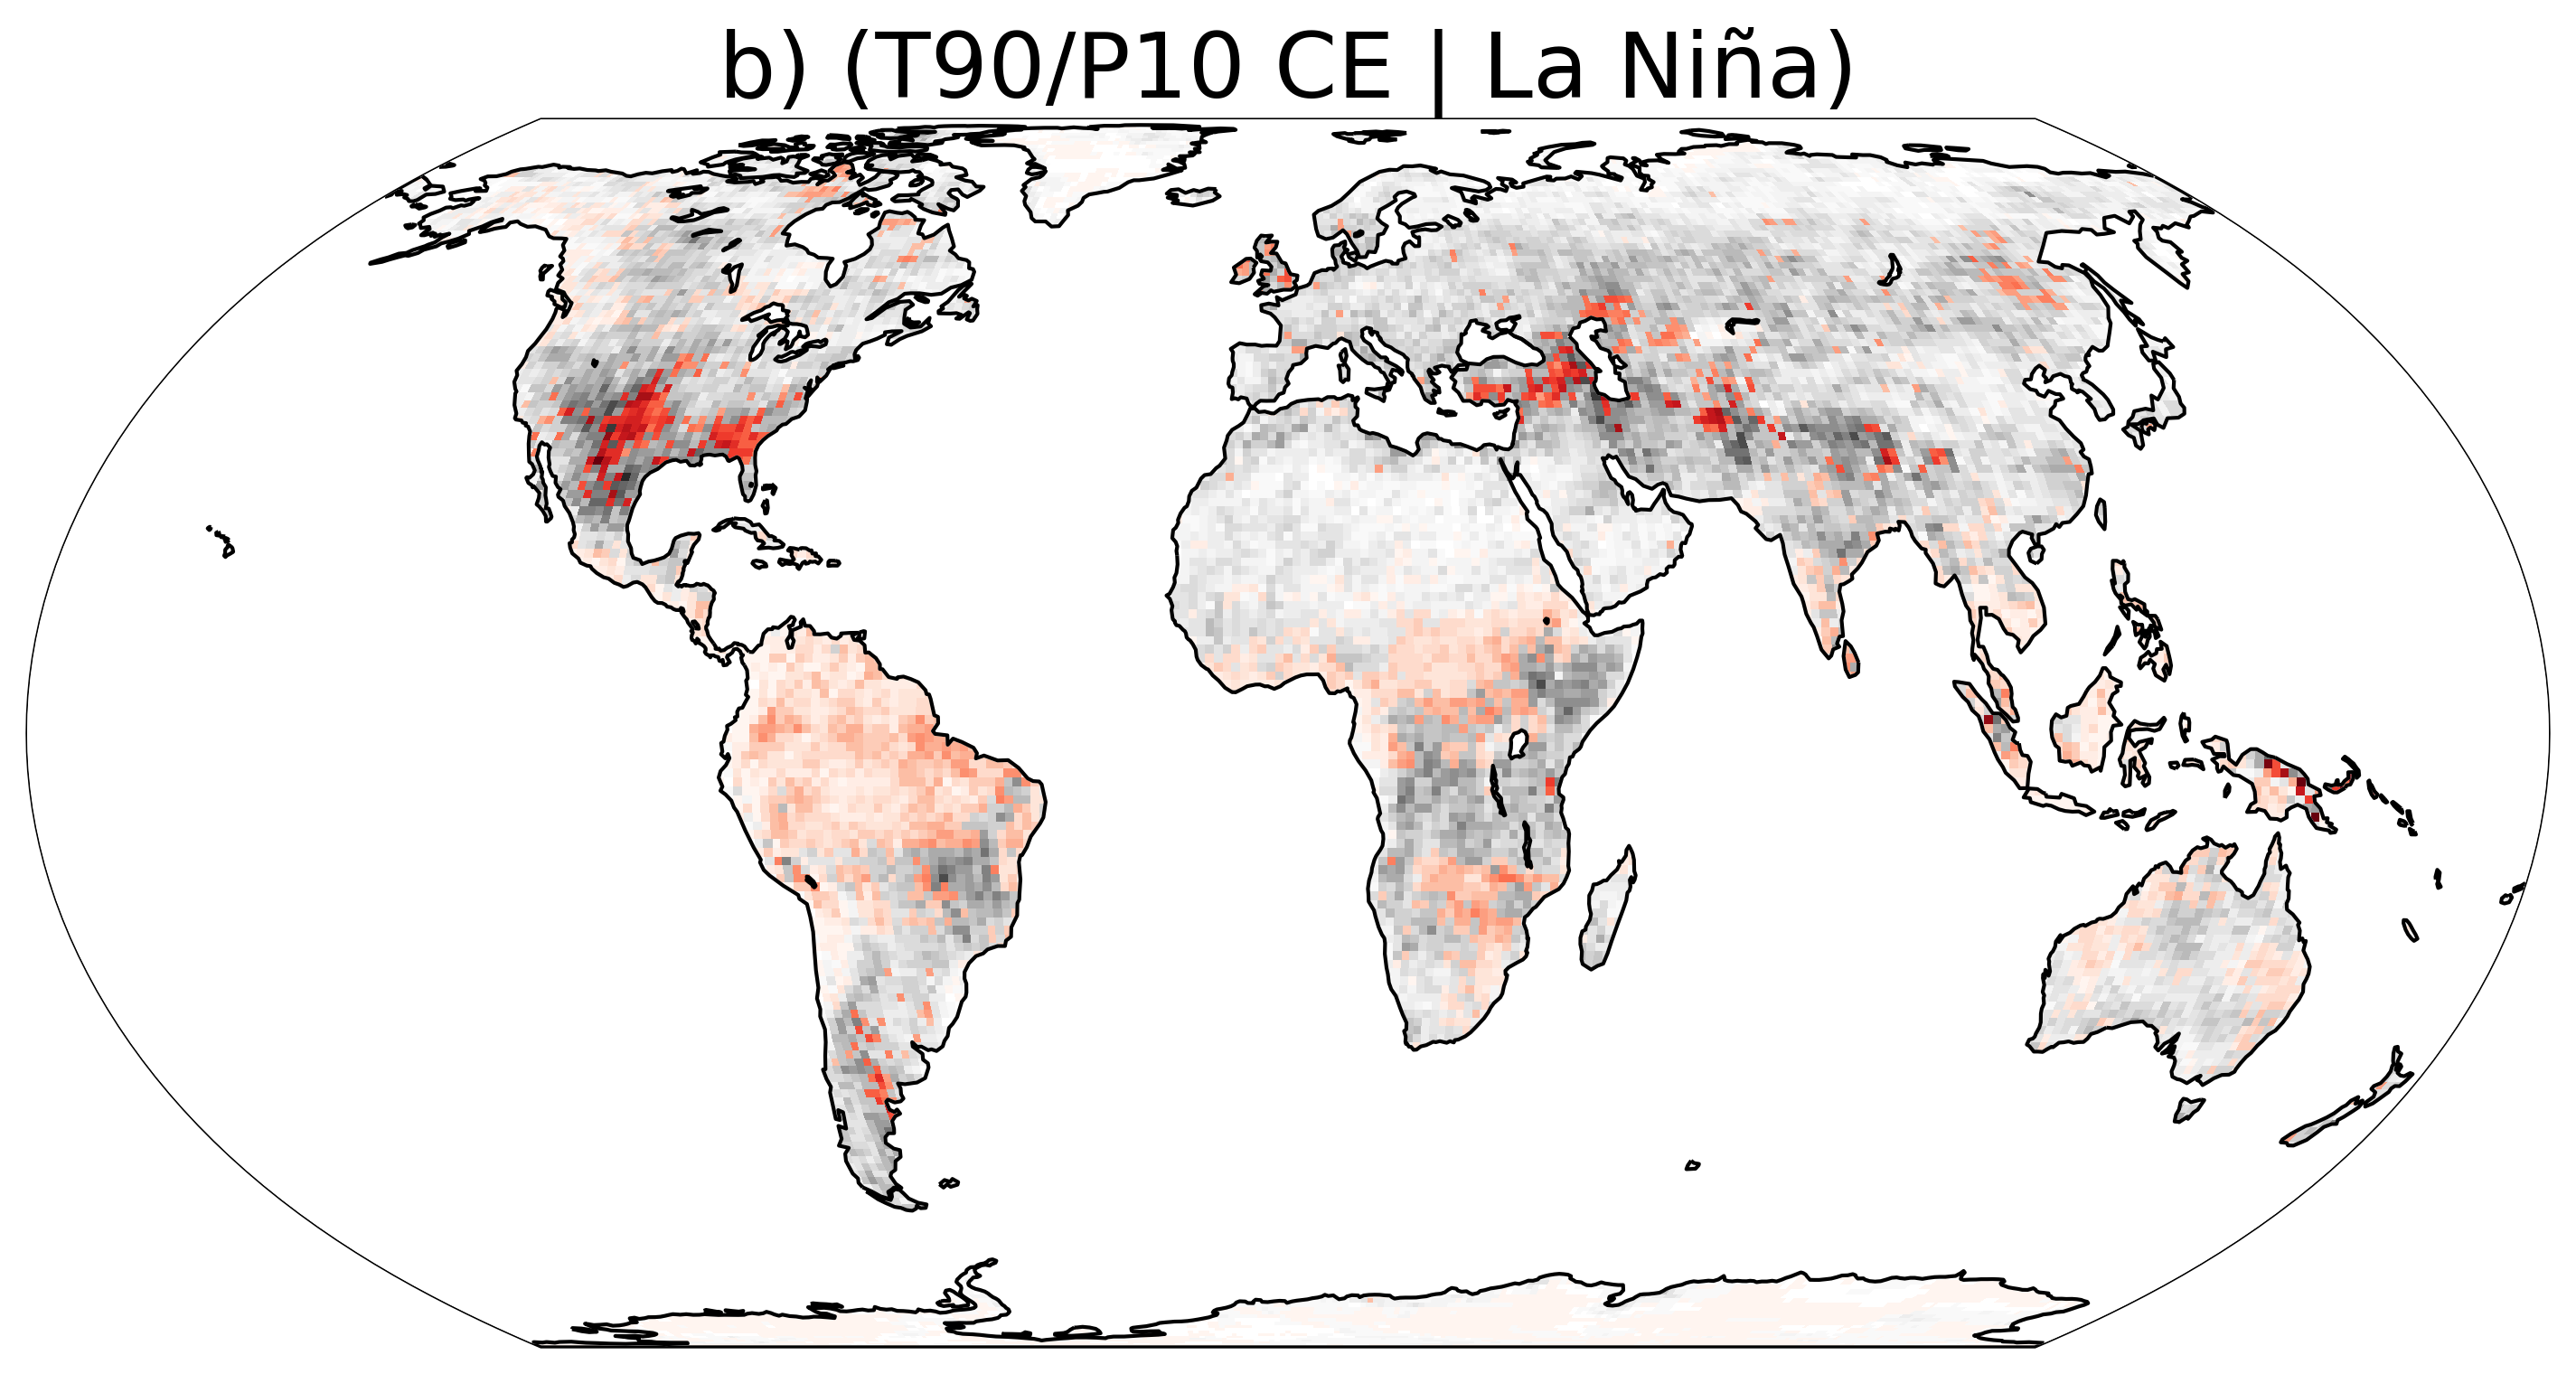

<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1

In [9]:
stipple_points = np.where(chi_squared <= 5.991, ces_given_enso, np.nan)   # if you want stippling uncomment what is below and then take out the last two conditions of the np.where
# Apply latitude bounds to exclude Antarctica
#lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
#ces_given_enso_filtered = ces_given_enso.where(ces_given_enso['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
#lat_mask = ces_given_enso['lat'].values > lat_bounds

# Apply the mask to the chi_squared numpy array
#stipple_test_filtered = chi_squared[lat_mask, :]

# Ensure the stipple_test_filtered has the same shape as ces_given_enso_filtered
stipple_points_filtered = np.where(chi_squared <= 3.841, ces_given_enso, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_enso['lon']
lat = ces_given_enso['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.EqualEarth())
plt.pcolormesh(lon, lat, ces_given_enso, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')


plt.title("b) (T90/P10 CE | La Niña)", size = 24)

plt.pcolormesh(lon, lat, stipple_points_filtered, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)
plt.show()

stipple_points_filtered - ces_given_enso


[CES | NAO]

<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[326., 326., 326., ..., 326., 326., 326.],
       [326., 326., 326., ..., 326., 326., 326.],
       [326., 326., 326., ..., 326., 326., 326.],
       ...,
       [326., 326., 326., ..., 326., 326., 326.],
       [326., 326., 326., ..., 326., 326., 326.],
       [326., 326., 326., ..., 326., 326., 326.]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1


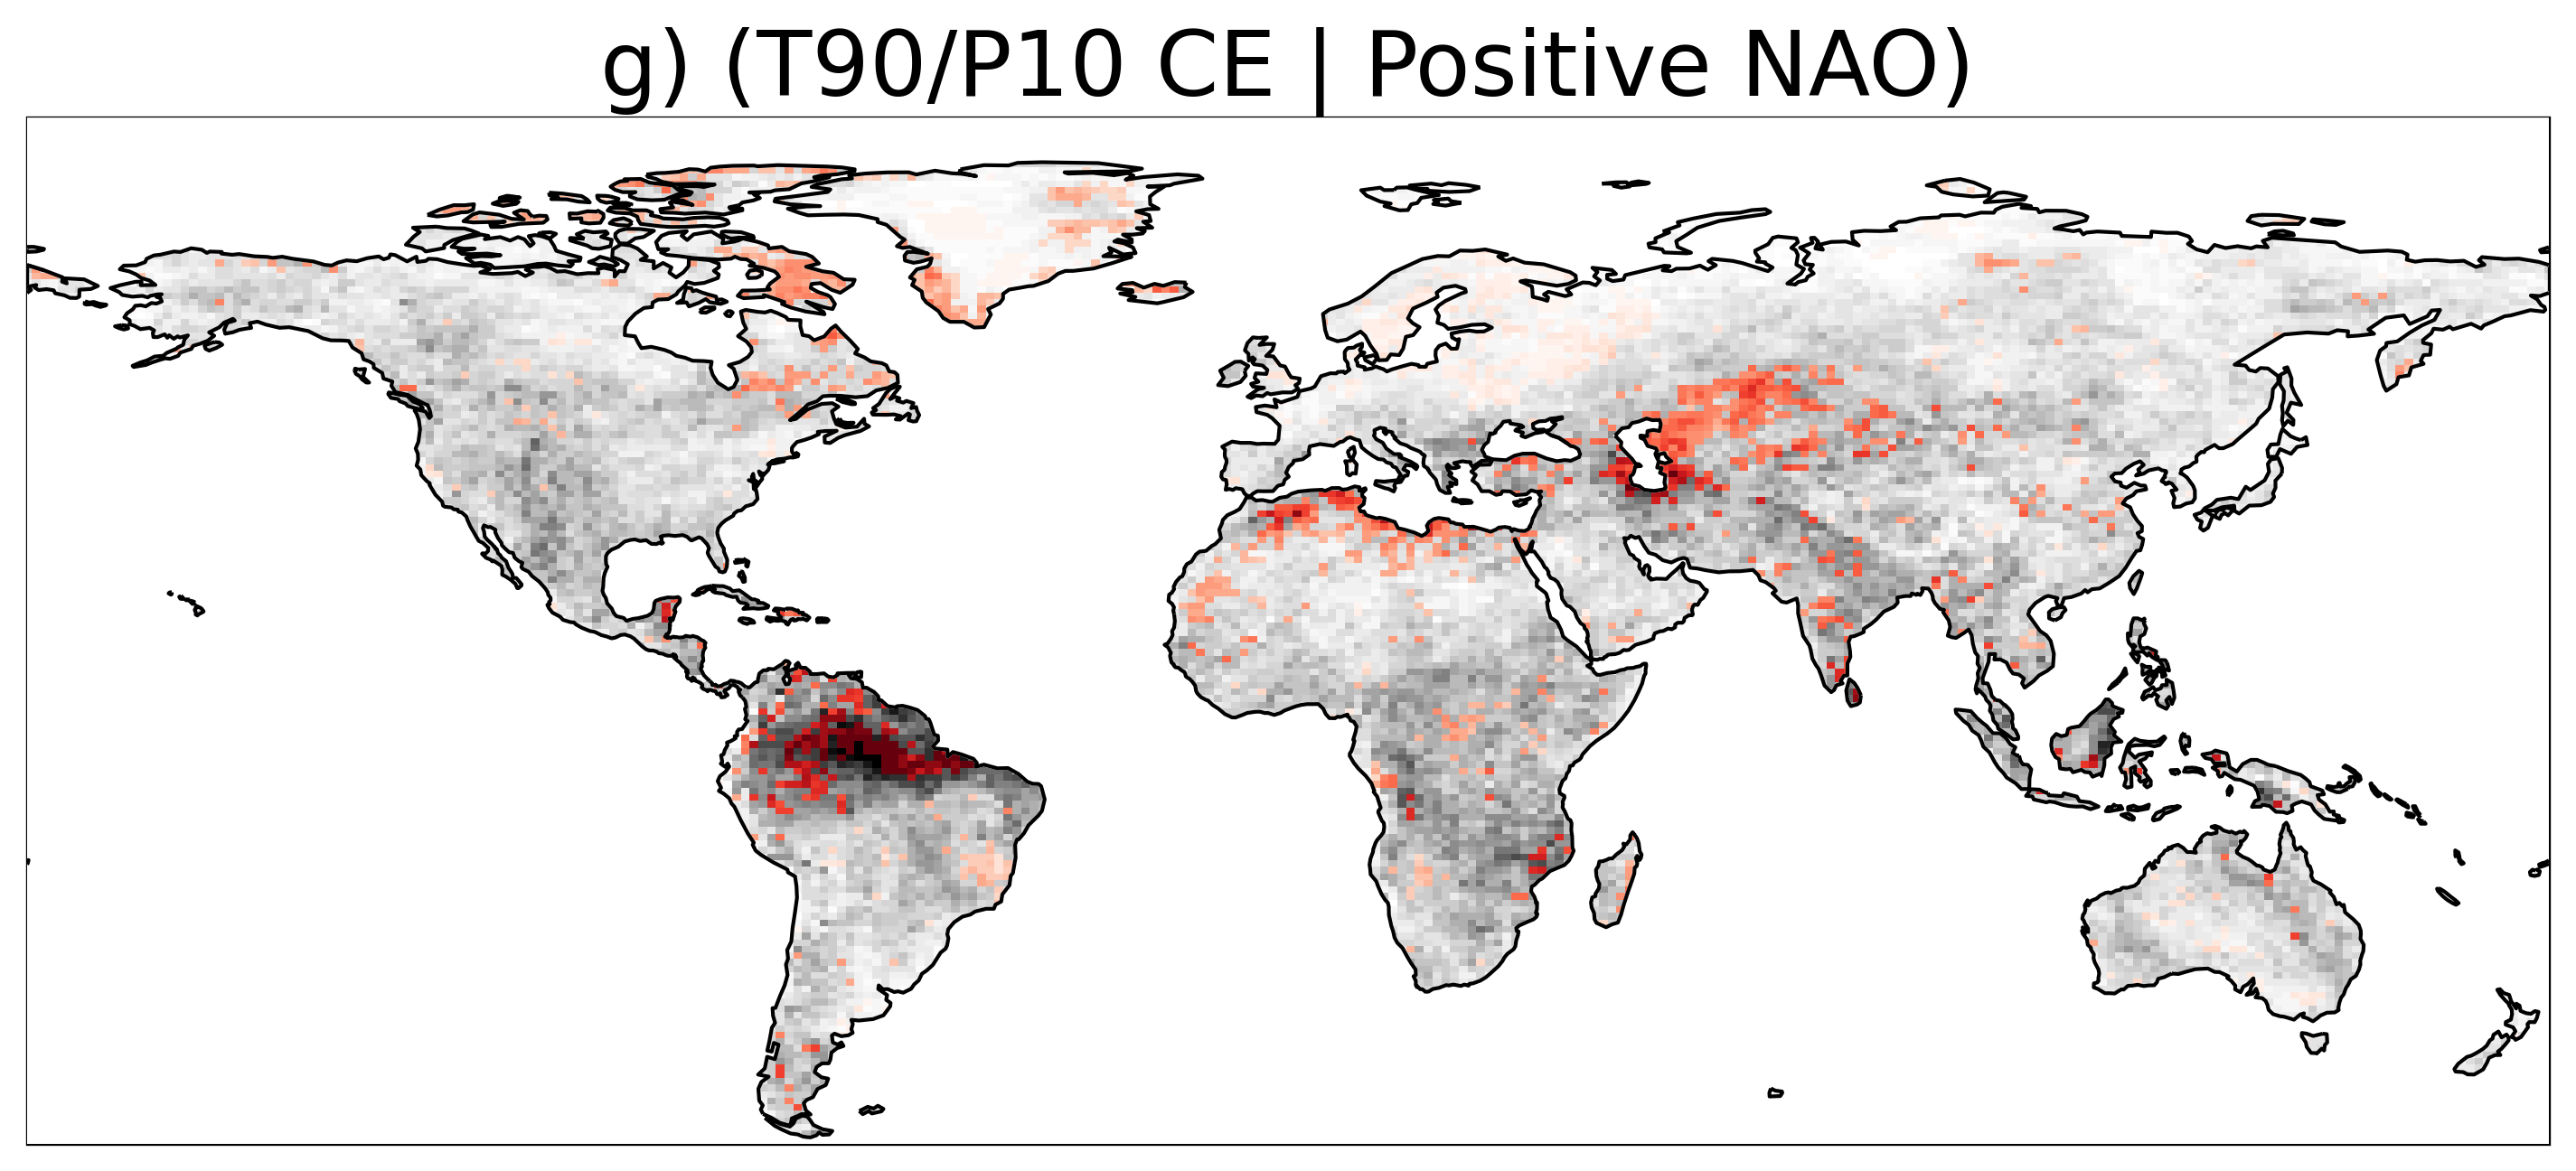

<xarray.DataArray (lat: 156, lon: 288)> Size: 359kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 1kB -56.07 -55.13 -54.19 -53.25 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1

In [10]:
### NEED TO CHANGE THE MODE PHASE, WHETHER IT IS [CES | MODE] OR [MODE | CES], THEN LABELS FOR PLOTTING AND THE BOUNDS OF THE PLOT ###

#  Find [CE | Mode] or the reverse

# Detrend the mode
mode_detrended = xr.DataArray(np.array(nao_anoms_1950_2023), dims=["time"], coords={"time": np.arange(len(np.array(nao_anoms_1950_2023)))})

# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008 - 12]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008 -12]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask = (mode_detrended_expanded <= -0.5) * 1

# Shift the ENSO indices by one month
mode_mask = mode_mask.shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask = (mode_mask == 1) & (ce_binary[120:1008 -12] == 1)

# get the count of matching 1s
matching_count = np.sum(matching_indices_mask, axis = 0)
true_indices_CES_count = np.sum(ce_binary[120:1008 -12], axis = 0)
true_indices_NAO_count = np.sum(mode_mask, axis = 0)

# Compute the probability
ces_given_NAO = (matching_count / true_indices_NAO_count) * 100
print(true_indices_NAO_count)



# Run the chi-squared test

# Define the sum for the probability of a compound event (CE) given an ENSO event
mode_detrended = xr.DataArray(np.array(nao_anoms_1950_2023), dims=["time"], coords={"time": np.arange(len(np.array(nao_anoms_1950_2023)))})
# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008 -12]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008 -12]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008 -12]['lat'], lon=ce_binary[120:1008 -12]['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask_pos_nao = ((mode_detrended_expanded >= 0.5) * 1).shift(time = 0)
mode_mask_neg_nao = ((mode_detrended_expanded <= -0.5) * 1).shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask_pos_nao_ce = np.sum((mode_mask_pos_nao == 1) & (ce_binary[120:1008 -12] == 1), axis = 0)
matching_indices_mask_pos_nao_not_ce = np.sum((mode_mask_pos_nao == 1) & (ce_binary[120:1008 -12] != 1), axis = 0)


pos_nao_row_total = matching_indices_mask_pos_nao_ce + matching_indices_mask_pos_nao_not_ce

matching_indices_mask_neg_nao_ce = np.sum((mode_mask_neg_nao == 1) & (ce_binary[120:1008 -12] == 1), axis = 0)
matching_indices_mask_neg_nao_not_ce = np.sum((mode_mask_neg_nao == 1) & (ce_binary[120:1008 -12] != 1), axis = 0)


neg_nao_row_total = matching_indices_mask_neg_nao_ce + matching_indices_mask_neg_nao_not_ce

ce_column_total = matching_indices_mask_pos_nao_ce + matching_indices_mask_neg_nao_ce
not_ce_column_total = matching_indices_mask_pos_nao_not_ce + matching_indices_mask_neg_nao_not_ce

expected_pos_nao_ce = (pos_nao_row_total * ce_column_total) / (pos_nao_row_total + neg_nao_row_total)
expected_pos_nao_not_ce = (pos_nao_row_total * not_ce_column_total) / (pos_nao_row_total + neg_nao_row_total)

expected_neg_nao_ce = (neg_nao_row_total * ce_column_total) / (pos_nao_row_total + neg_nao_row_total)
expected_neg_nao_not_ce = (neg_nao_row_total * not_ce_column_total) / (pos_nao_row_total + neg_nao_row_total)


pos_nao_ce = ((matching_indices_mask_pos_nao_ce - expected_pos_nao_ce)**2) / expected_pos_nao_ce
pos_nao_not_ce = ((matching_indices_mask_pos_nao_not_ce - expected_pos_nao_not_ce)**2) / expected_pos_nao_not_ce

neg_nao_ce = ((matching_indices_mask_neg_nao_ce - expected_neg_nao_ce)**2) / expected_neg_nao_ce
neg_nao_not_ce = ((matching_indices_mask_neg_nao_not_ce - expected_neg_nao_not_ce)**2) / expected_neg_nao_not_ce

chi_squared = pos_nao_ce + pos_nao_not_ce + neg_nao_ce + neg_nao_not_ce


# Plot the [CE | Mode] or reverse with the chi-squared test

lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
ces_given_NAO_filtered = ces_given_NAO.where(ces_given_NAO['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
lat_mask = ces_given_NAO['lat'].values > lat_bounds

# Apply the mask to the chi_squared numpy array
stipple_test_filtered = chi_squared[lat_mask, :]

# Ensure the stipple_test_filtered has the same shape as ces_given_NAO_filtered
stipple_points_filtered = np.where(stipple_test_filtered <= 3.841, ces_given_NAO_filtered, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_NAO_filtered['lon']
lat = ces_given_NAO_filtered['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon, lat, ces_given_NAO_filtered, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)
#cbar = plt.colorbar(orientation = 'horizontal', pad = 0.01, fraction = 0.05, extend = 'max', shrink = 1.4, label = 'Conditional Frequency (%)')
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')

plt.title("g) (T90/P10 CE | Positive NAO)", size = 24)

plt.pcolormesh(lon, lat, stipple_points_filtered, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)

plt.show()

stipple_points_filtered - ces_given_NAO_filtered

[CES | PDO]

In [ ]:
### NEED TO CHANGE THE MODE PHASE, WHETHER IT IS [CES | MODE] OR [MODE | CES], THEN LABELS FOR PLOTTING AND THE BOUNDS OF THE PLOT ###

#  Find [CE | Mode] or the reverse

# Detrend the mode
mode_detrended = xr.DataArray(np.array(pdo_anoms_1950_2024), dims=["time"], coords={"time": np.arange(len(np.array(pdo_anoms_1950_2024)))})

# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask = (mode_detrended_expanded <= -0.5) * 1

# Shift the ENSO indices by one month
mode_mask = mode_mask.shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask = (mode_mask == 1) & (ce_binary[120:1008] == 1)

# get the count of matching 1s
matching_count = np.sum(matching_indices_mask, axis = 0)
true_indices_CES_count = np.sum(ce_binary[120:1008], axis = 0)
true_indices_PDO_count = np.sum(mode_mask, axis = 0)

# Compute the probability
ces_given_pdo = (matching_count / true_indices_PDO_count) * 100
print(true_indices_PDO_count)


# Run the chi-squared test

# Define the sum for the probability of a compound event (CE) given an ENSO event
mode_detrended = xr.DataArray(np.array(pdo_anoms_1950_2024), dims=["time"], coords={"time": np.arange(len(np.array(pdo_anoms_1950_2024)))})
# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008]['lat'], lon=ce_binary[120:1008]['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask_pos_pdo = ((mode_detrended_expanded >= 0.5) * 1).shift(time = 0)
mode_mask_neg_pdo = ((mode_detrended_expanded <= -0.5) * 1).shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask_pos_pdo_ce = np.sum((mode_mask_pos_pdo == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_pos_pdo_not_ce = np.sum((mode_mask_pos_pdo == 1) & (ce_binary[120:1008] != 1), axis = 0)


pos_pdo_row_total = matching_indices_mask_pos_pdo_ce + matching_indices_mask_pos_pdo_not_ce

matching_indices_mask_neg_pdo_ce = np.sum((mode_mask_neg_pdo == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_neg_pdo_not_ce = np.sum((mode_mask_neg_pdo == 1) & (ce_binary[120:1008] != 1), axis = 0)


neg_pdo_row_total = matching_indices_mask_neg_pdo_ce + matching_indices_mask_neg_pdo_not_ce

ce_column_total = matching_indices_mask_pos_pdo_ce + matching_indices_mask_neg_pdo_ce
not_ce_column_total = matching_indices_mask_pos_pdo_not_ce + matching_indices_mask_neg_pdo_not_ce

expected_pos_pdo_ce = (pos_pdo_row_total * ce_column_total) / (pos_pdo_row_total + neg_pdo_row_total)
expected_pos_pdo_not_ce = (pos_pdo_row_total * not_ce_column_total) / (pos_pdo_row_total + neg_pdo_row_total)

expected_neg_pdo_ce = (neg_pdo_row_total * ce_column_total) / (pos_pdo_row_total + neg_pdo_row_total)
expected_neg_pdo_not_ce = (neg_pdo_row_total * not_ce_column_total) / (pos_pdo_row_total + neg_pdo_row_total)


pos_pdo_ce = ((matching_indices_mask_pos_pdo_ce - expected_pos_pdo_ce)**2) / expected_pos_pdo_ce
pos_pdo_not_ce = ((matching_indices_mask_pos_pdo_not_ce - expected_pos_pdo_not_ce)**2) / expected_pos_pdo_not_ce

neg_pdo_ce = ((matching_indices_mask_neg_pdo_ce - expected_neg_pdo_ce)**2) / expected_neg_pdo_ce
neg_pdo_not_ce = ((matching_indices_mask_neg_pdo_not_ce - expected_neg_pdo_not_ce)**2) / expected_neg_pdo_not_ce

chi_squared = pos_pdo_ce + pos_pdo_not_ce + neg_pdo_ce + neg_pdo_not_ce

# Plot the [CE | Mode] or reverse with the chi-squared test

lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
ces_given_PDO_filtered = ces_given_pdo.where(ces_given_pdo['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
lat_mask = ces_given_pdo['lat'].values > lat_bounds

# Apply the mask to the chi_squared numpy array
stipple_test_filtered = chi_squared[lat_mask, :]

# Ensure the stipple_test_filtered has the same shape as ces_given_PDO_filtered
stipple_points_filtered = np.where(stipple_test_filtered <= 3.841, ces_given_PDO_filtered, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_PDO_filtered['lon']
lat = ces_given_PDO_filtered['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon, lat, ces_given_PDO_filtered, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')

plt.title("c) (T90/P10 CE | Positive PDO)", size = 24)

plt.pcolormesh(lon, lat, stipple_points_filtered, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)

plt.show()

stipple_points_filtered - ces_given_PDO_filtered


[CES | IOD]

In [ ]:
### NEED TO CHANGE THE MODE PHASE, WHETHER IT IS [CES | MODE] OR [MODE | CES], THEN LABELS FOR PLOTTING AND THE BOUNDS OF THE PLOT ###

#  Find [CE | Mode] or the reverse

# Detrend the mode
mode_detrended = xr.DataArray(np.array(iod_anoms_1950_2024), dims=["time"], coords={"time": np.arange(len(np.array(iod_anoms_1950_2024)))})

# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask = (mode_detrended_expanded <= -0.5) * 1

# Shift the ENSO indices by one month
mode_mask = mode_mask.shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask = (mode_mask == 1) & (ce_binary[120:1008] == 1)

# get the count of matching 1s
matching_count = np.sum(matching_indices_mask, axis = 0)
true_indices_CES_count = np.sum(ce_binary[120:1008], axis = 0)
true_indices_IOD_count = np.sum(mode_mask, axis = 0)

# Compute the probability
ces_given_iod = (matching_count / true_indices_IOD_count) * 100
print(true_indices_IOD_count)


# Run the chi-squared test

# Define the sum for the probability of a compound event (CE) given an ENSO event
mode_detrended = xr.DataArray(np.array(iod_anoms_1950_2024), dims=["time"], coords={"time": np.arange(len(np.array(iod_anoms_1950_2024)))})
# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008]['lat'], lon=ce_binary[120:1008]['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask_pos_iod = ((mode_detrended_expanded >= 0.5) * 1).shift(time = 0)
mode_mask_neg_iod = ((mode_detrended_expanded <= -0.5) * 1).shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask_pos_iod_ce = np.sum((mode_mask_pos_iod == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_pos_iod_not_ce = np.sum((mode_mask_pos_iod == 1) & (ce_binary[120:1008] != 1), axis = 0)


pos_iod_row_total = matching_indices_mask_pos_iod_ce + matching_indices_mask_pos_iod_not_ce

matching_indices_mask_neg_iod_ce = np.sum((mode_mask_neg_iod == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_neg_iod_not_ce = np.sum((mode_mask_neg_iod == 1) & (ce_binary[120:1008] != 1), axis = 0)


neg_iod_row_total = matching_indices_mask_neg_iod_ce + matching_indices_mask_neg_iod_not_ce

ce_column_total = matching_indices_mask_pos_iod_ce + matching_indices_mask_neg_iod_ce
not_ce_column_total = matching_indices_mask_pos_iod_not_ce + matching_indices_mask_neg_iod_not_ce

expected_pos_iod_ce = (pos_iod_row_total * ce_column_total) / (pos_iod_row_total + neg_iod_row_total)
expected_pos_iod_not_ce = (pos_iod_row_total * not_ce_column_total) / (pos_iod_row_total + neg_iod_row_total)

expected_neg_iod_ce = (neg_iod_row_total * ce_column_total) / (pos_iod_row_total + neg_iod_row_total)
expected_neg_iod_not_ce = (neg_iod_row_total * not_ce_column_total) / (pos_iod_row_total + neg_iod_row_total)


pos_iod_ce = ((matching_indices_mask_pos_iod_ce - expected_pos_iod_ce)**2) / expected_pos_iod_ce
pos_iod_not_ce = ((matching_indices_mask_pos_iod_not_ce - expected_pos_iod_not_ce)**2) / expected_pos_iod_not_ce

neg_iod_ce = ((matching_indices_mask_neg_iod_ce - expected_neg_iod_ce)**2) / expected_neg_iod_ce
neg_iod_not_ce = ((matching_indices_mask_neg_iod_not_ce - expected_neg_iod_not_ce)**2) / expected_neg_iod_not_ce

chi_squared = pos_iod_ce + pos_iod_not_ce + neg_iod_ce + neg_iod_not_ce

# PLOT

lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
ces_given_IOD_filtered = ces_given_iod.where(ces_given_iod['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
lat_mask = ces_given_iod['lat'].values > lat_bounds

# Apply the mask to the chi_squared numpy array
stipple_test_filtered = chi_squared[lat_mask, :]

# Ensure the stipple_test_filtered has the same shape as ces_given_IOD_filtered
stipple_points_filtered = np.where(stipple_test_filtered <= 3.841, ces_given_IOD_filtered, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_IOD_filtered['lon']
lat = ces_given_IOD_filtered['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon, lat, ces_given_IOD_filtered, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')

plt.title("e) (T90/P10 CE | Positive IOD)", size = 24)

plt.pcolormesh(lon, lat, stipple_points_filtered, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)

plt.show()

Projections

In [ ]:
lat_c_comp = -2.85
lon_c_comp = 360-52.52

# pick out one location
location_ces_each_member = ce_binary[120:1008].sel(lat = lat_c_comp, lon = lon_c_comp, method = 'nearest')
# pull out the true indicies 
true_indices = [index for index, value in enumerate(location_ces_each_member) if value]

# temperature sum to average for the composite map
temp_sum = 0
# test to compare to the true indices sum earlier
test_i = 0

# loop through all the true indices for that member
for i in true_indices:
    if i == 0:
        print(i)
        next
    else:
    # add the temperature from whatever month you want around the index for the compound event to the sum
        temp_sum += detrended_surface_temps[i-1] # -1 for the month before
        test_i += 1
print(test_i)
composite_map_temperature = temp_sum / test_i


composite_map_temp = np.array(composite_map_temperature)
composite_flattened = composite_map_temp.flatten()

detrended_surface_temps_np = np.array(detrended_surface_temps[120:1008])
temp_reshape = detrended_surface_temps_np.reshape(detrended_surface_temps_np.shape[0], -1)

# Compute the dot product for each time step
dot_products = np.dot(temp_reshape, composite_flattened)

In [ ]:
date_range = pd.date_range(start = '1950-01', periods = len(ce_binary[120:1008]), freq = 'ME')

plt.figure(figsize = (12,6))
plt.axhline(0, color = 'lightgray')
plt.plot(date_range, dot_products / 55296, color = 'midnightblue', label = 'Projection') # / 55296
plt.plot(date_range, nino_34_anoms, color = 'red', label = 'ENSO Indices')

#plt.axvline(pd.Timestamp('1937-04'), color='red', linestyle='--', label='1974-11')
#plt.axvline(pd.Timestamp('1987-04'), color='red', linestyle='--', label='1974-11')


plt.title('ENSO Indices and Projection of SST Composite on ERA5 - NE Brazil')
plt.xlabel('Time')
plt.ylabel('ENSO Indices, Projection Correlation Scaled by # of grid cells')
plt.legend()
plt.show()

print(np.corrcoef(nino_34_anoms, dot_products)[0,1])


Projections for all locations and then correlated with ENSO

In [ ]:
enso_corr = True
pdo_corr = False
iod_corr = False

locations = [(-2.85, 360-52.52), (4.48, 31.36), (23.64, 87.80), (-0.54, 116.02), (38, 360-118.50)]#[(47.25, 360-122.44), (30.33, 360 - 81.66), (38.72, 360 - 9.14),(-33.87, 151.21),(35.68, 139.65),(-12.05, 360-77.04)]
location_names =['Northern Brazil', 'South Sudan', 'West Bengal, India', 'East Kalimantan, Indonesia', 'SW US']# ['Tacoma, WA', 'Jacksonville, FL', 'Lisbon, Portugal', 'Sydney, Australia', 'Tokyo, Japan', 'Lima, Peru']

# Initialize list to store the compound event averages per location
locations_correlations_list = []
# Loop through all locations
for lat_c, lon_c in locations:
    # Create list to hold all the true indices for compound events for one location
    true_indices_list = []

    # loop through all the members for the CE indices

    # pick out one location
    location_ces_each_member = ce_binary[120:1008].sel(lat = lat_c, lon = lon_c, method = 'nearest')
    # pull out the true indicies 
    true_indices = [index for index, value in enumerate(location_ces_each_member) if value]


    # temperature sum to average for the composite map
    temp_sum = 0
    # true indicies index to loop through the members from the true indices list
    true_indicies_i = 0
    # test to compare to the true indices sum earlier
    test_i = 0


    # loop through all the true indices for that member
    for i in true_indices:
        if i == 0:
            print(i)
            next
        else:
        # add the temperature from whatever month you want around the index for the compound event to the sum
            temp_sum += detrended_surface_temps[i-1] # -1 for the month before
            test_i += 1
    true_indicies_i += 1
    composite_map_temperature = temp_sum / test_i


    composite_map_temp = np.array(composite_map_temperature)
    composite_flattened = composite_map_temp.flatten()

    projections = []

    detrended_surface_temps_np = np.array(detrended_surface_temps[120:1008])
    temp_reshape = detrended_surface_temps_np.reshape(detrended_surface_temps_np.shape[0], -1)

    # Compute the dot product for each time step
    dot_products = np.dot(temp_reshape, composite_flattened)

    projections.append(dot_products)

    if enso_corr:
        correlations = np.corrcoef(nino_34_anoms, dot_products)[0,1]
        print(np.corrcoef(nino_34_anoms, dot_products)[0,1])


    
    locations_correlations_list.append(correlations)

putting all the compound events into a grid for visualization of when they are happening

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the date list
date_list = dates_where_ce_binary_is_1

# Extract years and months
dates = pd.to_datetime(date_list)
years = range(1940, 2024)
months = [f"{m:02d}" for m in range(1, 13)]

# Create a DataFrame with years as columns and months as index
df = pd.DataFrame(index=months, columns=years, data=False)

# Mark the dates in the DataFrame
for date in dates:
    year = date.year
    month = f"{date.month:02d}"
    if year in df.columns:
        df.at[month, year] = True

df.columns = [str(year)[-2:] for year in df.columns]

# Plot the table
fig, ax = plt.subplots(figsize=(20, 10))

# Prepare cell colors and text
cell_text = [['' for _ in df.columns] for _ in df.index]
cell_colors = df.applymap(lambda x: 'red' if x else 'white').values

# Create the table
table = ax.table(cellText=cell_text,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Adjust the table
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Hide the axes
ax.axis('off') 
plt.show()
